# Berkeley Hills CA-ID-TIMS date bar plot

This notebook generates the date bar plot which shows CA-ID-TIMS U-Pb dates developed in the Gerasimov et al. 2022 study and compares these dates to Ar-Ar dates developed in Wagner et al. 2021.

## Import scientific Python libraries for plotting

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

params = {'ytick.labelsize':'large'}
plt.rcParams.update(params)

%config InlineBackend.figure_format='retina'

## Define functions to calculate weighted means and generate date bar plot

In [2]:
def weighted_mean(dates,sigma):
    
    """
    calculated a weighted mean from dates and uncertainities
    
    input parameters
    ----------------
    dates: date of individual grains
    sigma: 1σ uncertainty associated with dates
    
    returns
    ----------------
    weighted_mean, 1σ uncertainty
    
    """
    
    inverse_variance=[]
    alpha=[]
    weighted_mean_calc=[]
    
    for n in range(0,len(dates)):
        value = 1/sigma[n]**2
        inverse_variance.append(value)
    inverse_variance_sum = np.sum(inverse_variance)
    
    for n in range(0,len(dates)):
        value = (1/sigma[n]**2)/inverse_variance_sum
        alpha.append(value)
        
    #calculate the weights for each date    
    for n in range(0,len(dates)):
        value = alpha[n]*dates[n]
        weighted_mean_calc.append(value)
    
    #take the sum of the weights multiplied by the dates to get the weighted
    #mean (equation 64 of McLean et al., 2011)
    weighted_mean = np.sum(weighted_mean_calc)
    
    #the variance of the weighted mean is simply the inverse of the sum of
    #the inverse variances of each date (equation 66 of McLean et al., 2011)
    variance = 1/inverse_variance_sum
    
    weighted_mean_sigma = np.sqrt(variance)
    
    n = len(dates)
    
    print('The weighted mean is:')

    print(weighted_mean)

    print('With a 2sigma error of:')

    print(2*weighted_mean_sigma)
    
    print('N=' )
    print(n)
    
    return weighted_mean, 2*weighted_mean_sigma

def plot_dates(zircon_means, zircon_2sigmas, include, sample_means, sample_2sigmas, colours, labels,\
               legend=True,figsize=None, ylim=None, lineweight=None, bbox_to_anchor=None):
    """
    Make a date distribution plot.
    
    inputs:
    - zircon_means = list of numpy arrays containing mean dates (each array being a sample)
    - zircon_2sigmas = list of numpy arrays containing 2sigmas (each array being a sample)
    - include = list of 'yes' or 'no' array for inclusion in mean (each array being a sample)
    - sample_means = list of sample mean dates (one per sample)
    - sample_2sigmas = list of sample 2sigmas (one per sample)
    - colours = list of colours (one per sample)
    - labels = list of labels (one per sample)
    - figsize = figure size (optional)
    - ylim = ylim (optional)
    - linewidth = zircon linewidth (optional)
    - bbox_to_anchor = for the legend (optional)
    """
    # formatting constants
    zircon_spacing = 0.9
    sample_spacing = 4 - zircon_spacing
    start_x = 3
    yes_alpha = 0.8
    no_alpha = 0.2
    x_positions = []
    if lineweight==None:
        lineweight=3
    
    # initialize current x
    current_x = start_x
    
    # number of samples
    n_samples = len(zircon_means)
    
    # plot
    if figsize == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    # iterate over each sample
    for i in range(n_samples):
        
        # number of zircons in sample
        n_zircons = len(zircon_means[i])
        
        # sample width
        sample_width = zircon_spacing*n_zircons
        
        # the 2sigma uncertainty on the sample age
        if sample_2sigmas != None:
            rectangle = matplotlib.patches.Rectangle((current_x, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)
            
        # the mean age
        if sample_means != None:
            ax.hlines(sample_means[i], current_x, current_x+sample_width,colors='C2')
            
        # legend control
        marked = False
        
        # iterate over each zircon
        for j in range(n_zircons):
            
            if marked:
                if include[i][j] == 'yes':
                    ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                              colors=colours[i], lw=lineweight, alpha=yes_alpha)
                else:
                    ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
            else:
                if include[i][j] == 'yes':
                    ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                              colors=colours[i], lw=lineweight, alpha=yes_alpha, label=labels[i])
                    marked = True
                else:
                    ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
                
            # tick the x to the next zircon
            current_x = current_x + zircon_spacing
        
        # tick the x to the next sample
        current_x = current_x + sample_spacing
        x_positions.append(current_x-sample_spacing)
    
    # prettify
    ax.invert_yaxis()
    ax.set_ylabel('age (Ma)',fontsize=16)
    if legend == True:
        if bbox_to_anchor == None:
            ax.legend(bbox_to_anchor=(1.8,1), fontsize=12)
        else:
            ax.legend(bbox_to_anchor=bbox_to_anchor, fontsize=12)
    if ylim != None:
        ax.set_ylim(ylim)
        
    return fig, ax, x_positions

## Import new U-Pb geochronology data

The dates that are imported are $^{206}$Pb/$^{238}$U dates developed via CA-ID-TIMS at Boise State University.

In [3]:
CSUF_4 = pd.read_csv('../data/CA_ID_TIMS/CSUF_4/CSUF_4_dates.csv')
CSUF_4.sort_values('206Pb/238U', inplace=True, ascending=False)
CSUF_4.reset_index(inplace=True)

OR24_2 = pd.read_csv('../data/CA_ID_TIMS/OR24_2/OR24_2_dates.csv')
OR24_2.sort_values('206Pb/238U', inplace=True, ascending=False)
OR24_2.reset_index(inplace=True)

MT24_1 = pd.read_csv('../data/CA_ID_TIMS/MT24_1/MT24_1_dates.csv')
MT24_1.sort_values('206Pb/238U', inplace=True, ascending=False)
MT24_1.reset_index(inplace=True)

## Calculate weighted means

In [4]:
OR24_2_filtered = OR24_2[OR24_2['include']=='yes']
OR24_2_filtered.reset_index(inplace=True)
OR24_2_date, OR24_2_2sigma = weighted_mean(OR24_2_filtered['206Pb/238U'],OR24_2_filtered['206Pb/238U_2sigma'])

The weighted mean is:
10.094
With a 2sigma error of:
0.028
N=
1


In [5]:
MT24_1_filtered = MT24_1[MT24_1['include']=='yes']
MT24_1_filtered.reset_index(inplace=True)
MT24_1_date, MT24_1_2sigma = weighted_mean(MT24_1_filtered['206Pb/238U'],MT24_1_filtered['206Pb/238U_2sigma']/2)

The weighted mean is:
9.973626437282388
With a 2sigma error of:
0.00808772030046732
N=
4


## Specify Ar-Ar dates

This Ar-Ar dates were published in Wagner et al. 2021. The dates were developed by Al Deino at the Berkeley Geochronology Center. The Moraga Tuff synomous with their "Berkeley Hills Tuff" and the Siesta Tuff is from the lacustrine sediments of the Siesta Formation above the Moraga Formation.

In [6]:
Moraga_Tuff_Ar_date = 9.8356
Moraga_Tuff_Ar_2sigma = 0.0076*2

Siesta_Tuff_Ar_date = 9.644
Siesta_Tuff_Ar_2sigma = 0.089*2

In [7]:
zircon_means = [CSUF_4['206Pb/238U'],
                OR24_2['206Pb/238U'],
                MT24_1['206Pb/238U']]
zircon_2sigmas = [CSUF_4['206Pb/238U_2sigma'],
                  OR24_2['206Pb/238U_2sigma'],
                  MT24_1['206Pb/238U_2sigma']]
include = [CSUF_4['include'],OR24_2['include'],MT24_1['include']]
sample_means = [0,0,MT24_1_date]
sample_2sigmas = [0,0,MT24_1_2sigma]
colors = ['black','black','black']
labels = ['Claremont Fm','Orinda Tuff clast','Moraga Tuff']

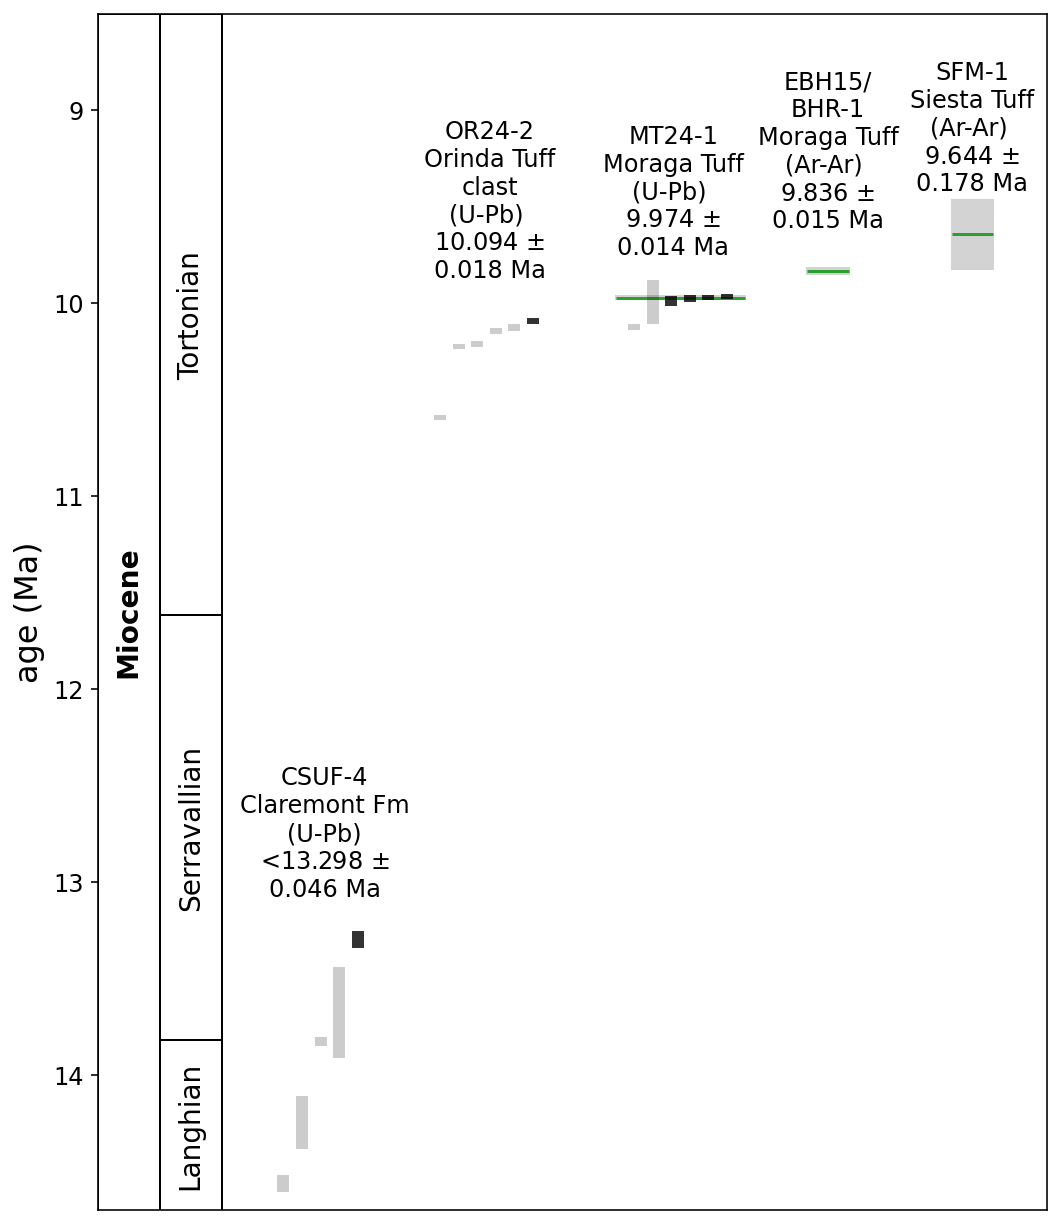

In [8]:
plot_age_min = 8.5
plot_age_max = 14.7

fig, ax, x_positions = plot_dates(zircon_means, zircon_2sigmas, 
                                  include, sample_means, sample_2sigmas, 
                                  colors, labels, legend=False, figsize=(8.5,11),lineweight=6)
ax.set_ylim(plot_age_max,plot_age_min)
ax.set_xlim(-6,40)
ax.tick_params(axis='x', labelsize=13)
ax.set_xticks([])
ax.text(x_positions[0]-(len(CSUF_4)/2),13.1,
        'CSUF-4\nClaremont Fm\n(U-Pb)\n<13.298 $\pm$\n0.046 Ma',
        size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)
ax.text(x_positions[1]-(len(OR24_2)/2),OR24_2_date-0.2,
        'OR24-2\nOrinda Tuff\nclast\n(U-Pb) \n10.094 $\pm$\n0.018 Ma',
        size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)
ax.text(x_positions[2]-(len(MT24_1)/2),MT24_1_date-0.2,
        'MT24-1\nMoraga Tuff\n(U-Pb) \n9.974 $\pm$\n0.014 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

Ar_x=x_positions[2]+3
Ar_width = 2
ax.hlines(Moraga_Tuff_Ar_date,Ar_x,Ar_x+Ar_width,color='C2')

Moraga_Tuff_Ar_error = matplotlib.patches.Rectangle((Ar_x, Moraga_Tuff_Ar_date-Moraga_Tuff_Ar_2sigma),\
                                         Ar_width, Moraga_Tuff_Ar_2sigma*2, color='lightgrey')
ax.add_patch(Moraga_Tuff_Ar_error)
ax.text(Ar_x+1,Moraga_Tuff_Ar_date-0.2,'EBH15/\nBHR-1\nMoraga Tuff\n(Ar-Ar) \n9.836 $\pm$\n0.015 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

Ar_x=x_positions[2]+10
ax.hlines(Siesta_Tuff_Ar_date,Ar_x,Ar_x+Ar_width,color='C2')

Siesta_Tuff_Ar_error = matplotlib.patches.Rectangle((Ar_x, Siesta_Tuff_Ar_date-Siesta_Tuff_Ar_2sigma),\
                                         Ar_width, Siesta_Tuff_Ar_2sigma*2, color='lightgrey')
ax.add_patch(Siesta_Tuff_Ar_error)
ax.text(Ar_x+1,Siesta_Tuff_Ar_date-0.2,'SFM-1\nSiesta Tuff\n(Ar-Ar) \n9.644 $\pm$\n0.178 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

ax.add_patch(matplotlib.patches.Rectangle((-6, plot_age_min), 3, 50, facecolor='white',edgecolor='black'))
ax.annotate('Miocene', (-4.5, (plot_age_max+plot_age_min)/2), color='black', weight='bold', 
            fontsize=14, ha='center', va='center',rotation=90)

#11.62 Serravallian - Tortonian boundary
#13.82 Langhian - Serravallian boundary
Serravallian_Tortonian = 11.62
Langhian_Serravallian = 13.82

ax.add_patch(matplotlib.patches.Rectangle((-3, Langhian_Serravallian), 
                                          3, 50, facecolor='white',edgecolor='black'))
ax.annotate('Langhian', (-1.5, (plot_age_max+Langhian_Serravallian)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

ax.add_patch(matplotlib.patches.Rectangle((-3, Serravallian_Tortonian), 
                                          3, Langhian_Serravallian-Serravallian_Tortonian, facecolor='white',edgecolor='black'))
ax.annotate('Serravallian', (-1.5, (Langhian_Serravallian+Serravallian_Tortonian)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

ax.add_patch(matplotlib.patches.Rectangle((-3, plot_age_min), 
                                          3, Serravallian_Tortonian-plot_age_min, facecolor='white',edgecolor='black'))
ax.annotate('Tortonian', (-1.5, (Serravallian_Tortonian+plot_age_min)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

plt.savefig('./Output/date_bar_plot.pdf')
plt.show()